# 05 - Fuzzy Inference System
## TCI6313 Computational Intelligence Project
### Rule-Based Fuzzy System for Interpretable Air Quality Prediction

---

**Objective:** Implement a Mamdani-type Fuzzy Inference System (FIS) as an interpretable CI baseline.

**Model Type:** Fuzzy Inference System (Rule-Based)

**CI Paradigm:** Fuzzy Systems

**CI Justification:**
- Fuzzy systems handle uncertainty and imprecision through linguistic variables
- Rules are human-interpretable (IF-THEN statements)
- Provides contrast to black-box neural network approaches
- Demonstrates knowledge-based vs. data-driven CI paradigms

**Role in Project:**
- Interpretable baseline for CI paradigm completeness
- Enables discussion of black-box vs. white-box models
- Shows rule-based reasoning in air quality domain

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
from datetime import datetime
import time
import json

# Add src to path
sys.path.insert(0, os.path.abspath('../src'))

# Import custom modules
from fuzzy_model import (
    MamdaniFIS, create_air_quality_fis,
    visualize_membership_functions, visualize_rule_surface
)
from preprocessing import load_air_quality_data, create_datetime_features, handle_missing_values
from evaluation import evaluate_model, save_results_to_json

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Display current time
print("="*60)
print(f"🕒 Current Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)
print("Libraries and modules imported successfully!")

🕒 Current Time: 2026-01-26 21:40:25
Libraries and modules imported successfully!


## 1. Data Loading and Preparation

We load the same dataset used by other models to ensure fair comparison.
For the Fuzzy system, we only need CO and NO2 as inputs (simplified for interpretability).

In [2]:
# Configuration
DATA_PATH = '../data/AirQuality.csv'
TARGET_COLUMN = 'C6H6(GT)'
INPUT_FEATURES = ['CO(GT)', 'NO2(GT)']  # Simplified 2-input FIS

# Use same test split as other models (15%)
TEST_SIZE = 0.15

print("="*60)
print("📊 FUZZY INFERENCE SYSTEM CONFIGURATION")
print("="*60)
print(f"Input Features: {INPUT_FEATURES}")
print(f"Output: {TARGET_COLUMN}")
print(f"Test Size: {TEST_SIZE*100:.0f}%")
print("="*60)

📊 FUZZY INFERENCE SYSTEM CONFIGURATION
Input Features: ['CO(GT)', 'NO2(GT)']
Output: C6H6(GT)
Test Size: 15%


In [3]:
# Load and preprocess data
print("\n📂 Loading data...")
df = load_air_quality_data(DATA_PATH)
df = create_datetime_features(df)
df = handle_missing_values(df, strategy='interpolate')

print(f"\nDataset shape after preprocessing: {df.shape}")

# Extract relevant columns
required_cols = INPUT_FEATURES + [TARGET_COLUMN]
df_fis = df[required_cols].copy()

print(f"\n📊 Data Statistics:")
print(df_fis.describe())


📂 Loading data...
[INFO] Loaded dataset with shape: (9357, 15)
[INFO] Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
[INFO] Created datetime features. New shape: (9357, 23)
[INFO] Missing values before handling: 16701
[INFO] Missing values after handling: 0
[INFO] Final shape after handling missing values: (924, 23)

Dataset shape after preprocessing: (924, 23)

📊 Data Statistics:
           CO(GT)     NO2(GT)    C6H6(GT)
count  924.000000  924.000000  924.000000
mean     2.257197   97.471320   10.268831
std      1.400467   32.280315    7.390375
min      0.300000   17.000000    0.500000
25%      1.200000   74.750000    4.100000
50%      2.000000   97.000000    8.700000
75%      3.000000  120.000000   14.400000
max      8.100000  196.000000   39.200000


In [4]:
# Get data statistics for FIS configuration
data_stats = {
    'CO_min': df_fis['CO(GT)'].min(),
    'CO_max': df_fis['CO(GT)'].max(),
    'NO2_min': df_fis['NO2(GT)'].min(),
    'NO2_max': df_fis['NO2(GT)'].max(),
    'C6H6_min': df_fis[TARGET_COLUMN].min(),
    'C6H6_max': df_fis[TARGET_COLUMN].max(),
}

print("\n📈 Data Ranges for FIS:")
print("-" * 40)
for key, value in data_stats.items():
    print(f"  {key}: {value:.2f}")


📈 Data Ranges for FIS:
----------------------------------------
  CO_min: 0.30
  CO_max: 8.10
  NO2_min: 17.00
  NO2_max: 196.00
  C6H6_min: 0.50
  C6H6_max: 39.20


In [5]:
# Split data (same split as other models)
n_samples = len(df_fis)
n_test = int(n_samples * TEST_SIZE)
n_train = n_samples - n_test

# Time-series split (no shuffle to maintain temporal order)
train_df = df_fis.iloc[:n_train]
test_df = df_fis.iloc[n_train:]

# Prepare arrays
X_train = train_df[INPUT_FEATURES].values
y_train = train_df[TARGET_COLUMN].values
X_test = test_df[INPUT_FEATURES].values
y_test = test_df[TARGET_COLUMN].values

print(f"\n📊 Data Split:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")


📊 Data Split:
  Training samples: 786
  Test samples: 138


## 2. Fuzzy Inference System Design

### Fuzzy System Components:

**Inputs (2 variables):**
- CO (Carbon Monoxide): Low / Medium / High
- NO2 (Nitrogen Dioxide): Low / Medium / High

**Output (1 variable):**
- C6H6 (Benzene): Low / Medium / High → defuzzified to numeric

**Membership Functions:** Triangular (3 per variable)

**Inference Method:** Mamdani with centroid defuzzification

In [6]:
# Create Fuzzy Inference System
print("="*60)
print("🔧 CREATING FUZZY INFERENCE SYSTEM")
print("="*60)

fis = create_air_quality_fis(data_stats)

# Print system summary
print(fis.summary())

🔧 CREATING FUZZY INFERENCE SYSTEM
FUZZY INFERENCE SYSTEM: AirQuality_C6H6_Predictor

INPUT VARIABLES:
----------------------------------------
  CO:
    Universe: (np.float64(0.3), np.float64(8.1))
    Terms: ['Low', 'Medium', 'High']
  NO2:
    Universe: (np.float64(17.0), np.float64(196.0))
    Terms: ['Low', 'Medium', 'High']

OUTPUT VARIABLE:
----------------------------------------
  C6H6:
    Universe: (np.float64(0.5), np.float64(39.2))
    Terms: ['Low', 'Medium', 'High']

RULES:
----------------------------------------
  R1: IF CO is Low AND NO2 is Low THEN C6H6 is Low
  R2: IF CO is Low AND NO2 is Medium THEN C6H6 is Low
  R3: IF CO is Low AND NO2 is High THEN C6H6 is Medium
  R4: IF CO is Medium AND NO2 is Low THEN C6H6 is Low
  R5: IF CO is Medium AND NO2 is Medium THEN C6H6 is Medium
  R6: IF CO is Medium AND NO2 is High THEN C6H6 is High
  R7: IF CO is High AND NO2 is Low THEN C6H6 is Medium
  R8: IF CO is High AND NO2 is Medium THEN C6H6 is High
  R9: IF CO is High AND N

## 3. Visualize Membership Functions

Membership functions define how crisp input values are mapped to fuzzy degrees.
We use triangular MFs with 3 linguistic terms (Low, Medium, High) per variable.

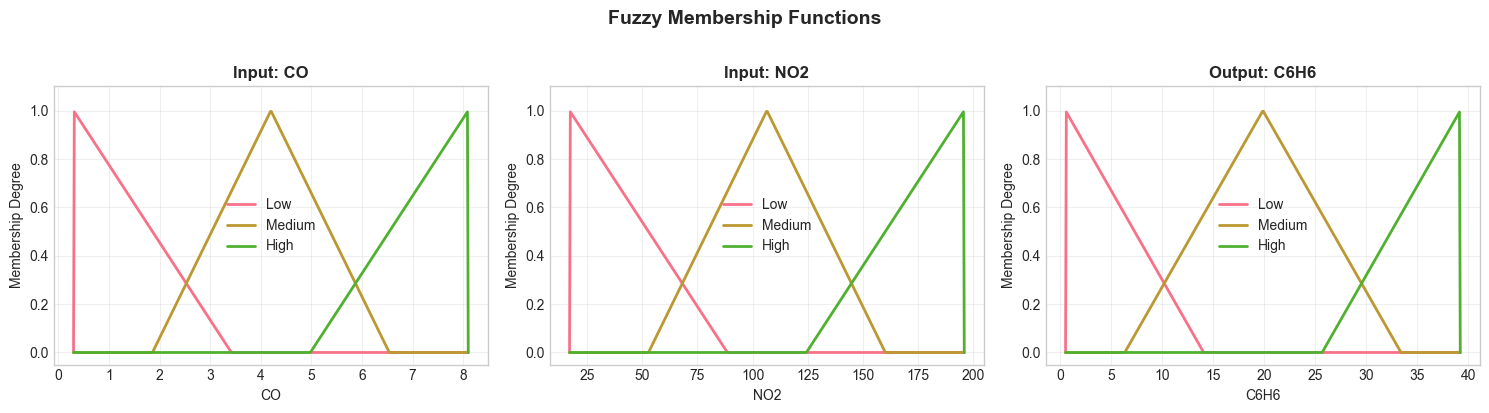


✅ Membership functions saved to results/fuzzy_membership_functions.png


In [7]:
# Visualize membership functions
fig = visualize_membership_functions(fis, save_path='../results/fuzzy_membership_functions.png')
plt.show()

print("\n✅ Membership functions saved to results/fuzzy_membership_functions.png")

## 4. Visualize Fuzzy Control Surface

The control surface shows how the FIS maps input combinations to output values.
This provides intuition about the rule-based reasoning.

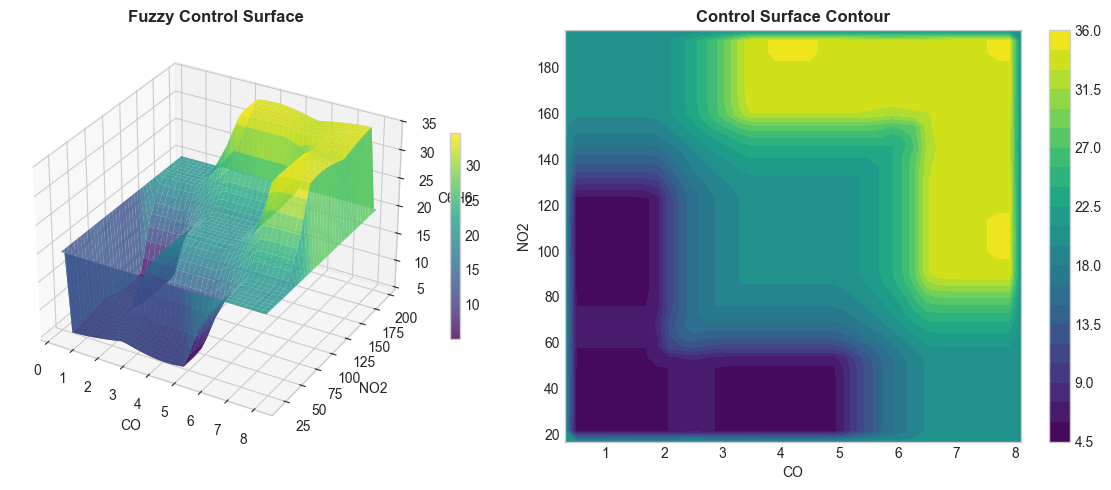


✅ Control surface saved to results/fuzzy_control_surface.png


In [8]:
# Visualize control surface
fig = visualize_rule_surface(fis, resolution=40, save_path='../results/fuzzy_control_surface.png')
plt.show()

print("\n✅ Control surface saved to results/fuzzy_control_surface.png")

## 5. Fuzzy Inference (Prediction)

Now we run the FIS on our test data to generate predictions.
The inference process:
1. Fuzzify inputs → membership degrees
2. Evaluate rules → firing strengths
3. Aggregate outputs → combined fuzzy set
4. Defuzzify → crisp output value

In [9]:
# Run inference on test set
print("="*60)
print("🔮 FUZZY INFERENCE (PREDICTION)")
print("="*60)
print(f"🕒 Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 Processing {len(X_test)} test samples...")
print("="*60)

# Map feature names for FIS
fis_input_names = ['CO', 'NO2']  # FIS uses simplified names

# Perform inference
start_time = time.time()
y_pred_test = fis.predict(X_test, input_names=fis_input_names, verbose=True)
inference_time = time.time() - start_time

print(f"\n✅ Inference completed in {inference_time:.2f} seconds")
print(f"🕒 End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🔮 FUZZY INFERENCE (PREDICTION)
🕒 Start Time: 2026-01-26 21:40:29
📊 Processing 138 test samples...
  Processed 100/138 samples...
  Inference completed in 0.05 seconds

✅ Inference completed in 0.05 seconds
🕒 End Time: 2026-01-26 21:40:29


In [10]:
# Also run on training set for comparison
print("\n📊 Processing training samples for comparison...")
y_pred_train = fis.predict(X_train, input_names=fis_input_names, verbose=True)


📊 Processing training samples for comparison...
  Processed 100/786 samples...
  Processed 200/786 samples...
  Processed 300/786 samples...
  Processed 400/786 samples...
  Processed 500/786 samples...
  Processed 600/786 samples...
  Processed 700/786 samples...
  Inference completed in 0.25 seconds


## 6. Model Evaluation

We evaluate the FIS using the same metrics as other models:
- RMSE (Root Mean Square Error)
- MAE (Mean Absolute Error)
- R² (Coefficient of Determination)

**Note:** Performance is expected to be lower than learning-based models.
The value of FIS is in interpretability, not accuracy.

In [11]:
# Evaluate on all sets
print("="*60)
print("FUZZY MODEL EVALUATION RESULTS")
print("="*60)

# Training set
train_metrics = evaluate_model(y_train, y_pred_train, 'Fuzzy-Train')
print(f"\nTraining Set:")
print(f"  RMSE: {train_metrics['rmse']:.4f}")
print(f"  MAE:  {train_metrics['mae']:.4f}")
print(f"  R²:   {train_metrics['r2']:.4f}")

# Test set
test_metrics = evaluate_model(y_test, y_pred_test, 'Fuzzy-Test',
                              training_time=inference_time)
print(f"\nTest Set:")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE:  {test_metrics['mae']:.4f}")
print(f"  R²:   {test_metrics['r2']:.4f}")

print(f"\nInference Time: {inference_time:.2f} seconds")
print("="*60)

FUZZY MODEL EVALUATION RESULTS

Training Set:
  RMSE: 4.5855
  MAE:  3.4410
  R²:   0.5986

Test Set:
  RMSE: 4.0266
  MAE:  2.9205
  R²:   0.7485

Inference Time: 0.05 seconds


## 7. Visualizations

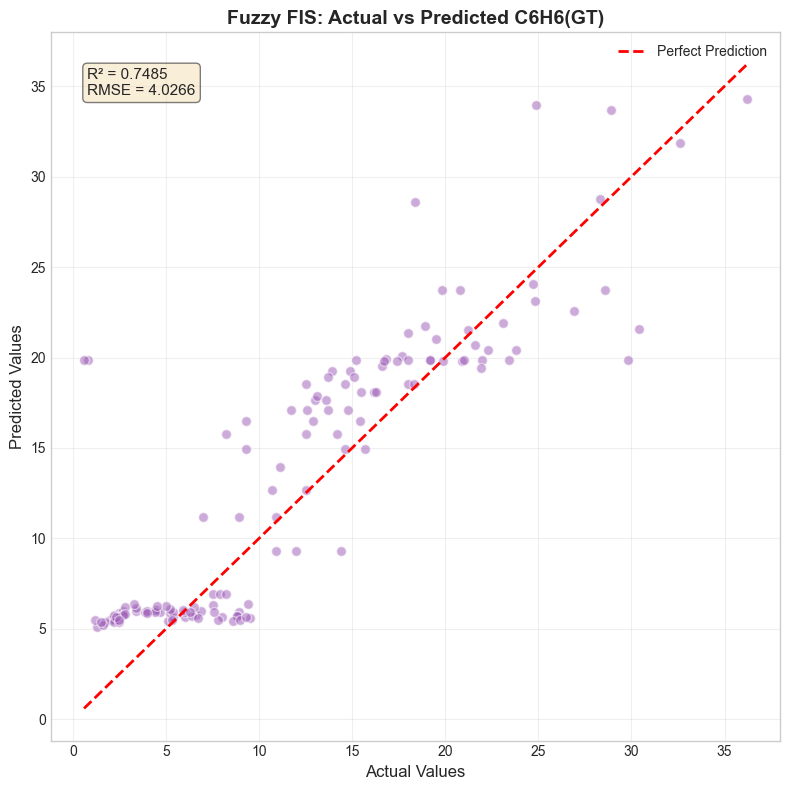

In [12]:
# Actual vs Predicted scatter plot
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(y_test, y_pred_test, alpha=0.5, c='#9b59b6', edgecolor='white', s=50)

# Perfect prediction line
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

ax.set_xlabel('Actual Values', fontsize=12)
ax.set_ylabel('Predicted Values', fontsize=12)
ax.set_title(f'Fuzzy FIS: Actual vs Predicted {TARGET_COLUMN}', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Add metrics text
textstr = f'R² = {test_metrics["r2"]:.4f}\nRMSE = {test_metrics["rmse"]:.4f}'
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../results/fuzzy_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

Plotting last 138 test samples (total test samples: 138)


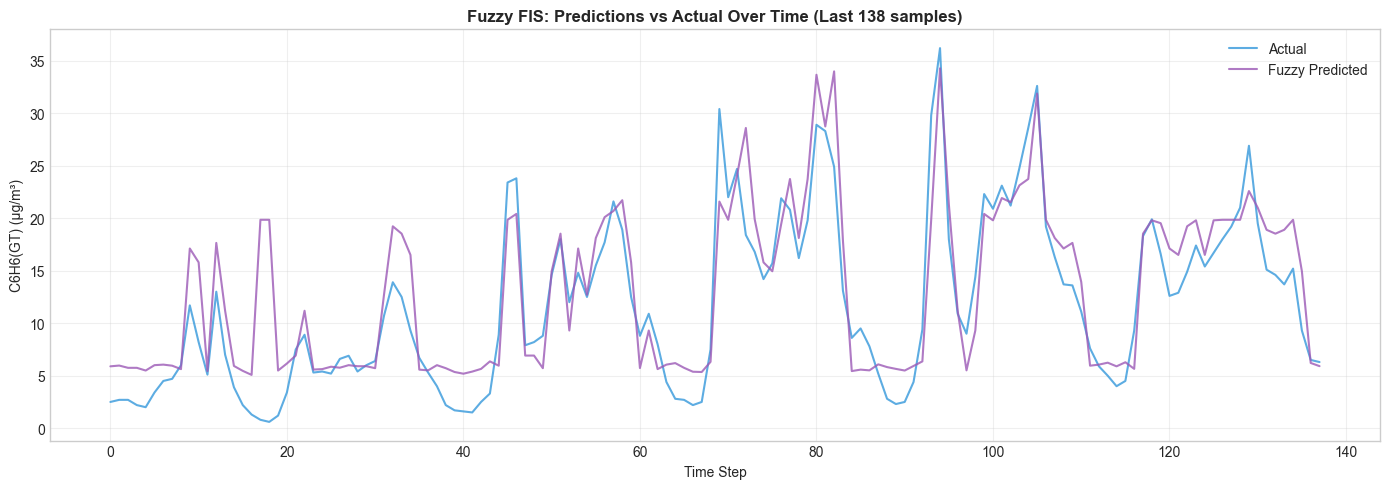

In [13]:
# Predictions over time
n_points = min(200, len(y_test))
print(f"Plotting last {n_points} test samples (total test samples: {len(y_test)})")

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(range(n_points), y_test[-n_points:], label='Actual', alpha=0.8, lw=1.5, color='#3498db')
ax.plot(range(n_points), y_pred_test[-n_points:], label='Fuzzy Predicted', alpha=0.8, lw=1.5, color='#9b59b6')
ax.set_xlabel('Time Step')
ax.set_ylabel(f'{TARGET_COLUMN} (µg/m³)')
ax.set_title(f'Fuzzy FIS: Predictions vs Actual Over Time (Last {n_points} samples)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/fuzzy_predictions_time.png', dpi=150, bbox_inches='tight')
plt.show()

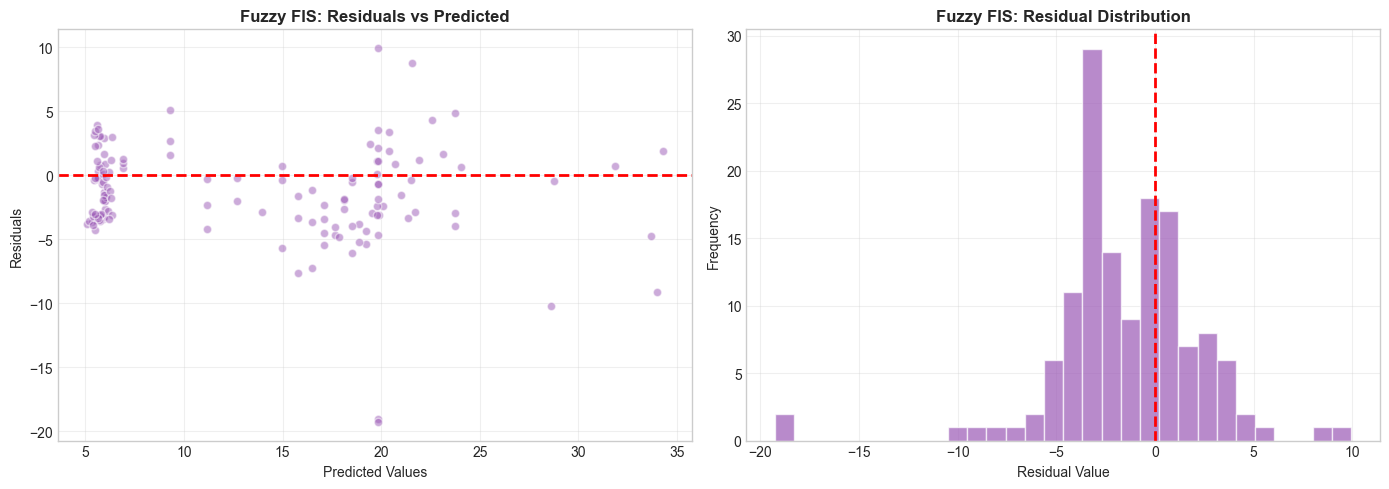

In [14]:
# Residual analysis
residuals = y_test - y_pred_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Predicted
axes[0].scatter(y_pred_test, residuals, alpha=0.5, c='#9b59b6', edgecolor='white')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Fuzzy FIS: Residuals vs Predicted', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=30, color='#9b59b6', edgecolor='white', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Fuzzy FIS: Residual Distribution', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/fuzzy_residuals.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Results

In [15]:
# Compile results
fuzzy_results = {
    'model_type': 'Fuzzy Inference System',
    'ci_paradigm': 'Fuzzy Systems',
    'model_config': {
        'type': 'Mamdani FIS',
        'inputs': INPUT_FEATURES,
        'output': TARGET_COLUMN,
        'membership_functions': 'Triangular',
        'terms_per_variable': 3,
        'defuzzification': 'Centroid',
        'n_rules': len(fis.rules)
    },
    'rules': [str(rule) for rule in fis.rules],
    'data_stats': data_stats,
    'metrics': {
        'train': train_metrics,
        'test': test_metrics
    },
    'inference_time': inference_time,
    'predictions': {
        'test_actual': y_test.tolist(),
        'test_predicted': y_pred_test.tolist()
    }
}

# Save to JSON
save_results_to_json(fuzzy_results, '../results/fuzzy_results.json')
print("Results saved to ../results/fuzzy_results.json!")

[INFO] Results saved to ../results/fuzzy_results.json
Results saved to ../results/fuzzy_results.json!


## 9. Example Inference Trace

To demonstrate interpretability, we show the complete inference process for a sample input.

In [16]:
# Demonstrate inference trace for a sample
sample_idx = 50
sample_input = {'CO': X_test[sample_idx, 0], 'NO2': X_test[sample_idx, 1]}
actual_value = y_test[sample_idx]

print("="*60)
print("🔍 INFERENCE TRACE (Sample #{})" .format(sample_idx))
print("="*60)
print(f"\n📥 INPUT VALUES:")
print(f"   CO:  {sample_input['CO']:.2f} mg/m³")
print(f"   NO2: {sample_input['NO2']:.2f} µg/m³")

# Run inference with details
output, details = fis.infer(sample_input)

print(f"\n📊 FUZZIFICATION:")
for var_name, memberships in details['fuzzified_inputs'].items():
    print(f"   {var_name}:")
    for term, degree in memberships.items():
        bar = '█' * int(degree * 20)
        print(f"      {term:8s}: {degree:.3f} |{bar}")

print(f"\n📋 RULE EVALUATIONS:")
for i, rule_eval in enumerate(details['rule_evaluations'], 1):
    if rule_eval['firing_strength'] > 0:
        print(f"   R{i}: Strength={rule_eval['firing_strength']:.3f} → {rule_eval['output_term']}")

print(f"\n📤 OUTPUT:")
print(f"   Predicted C6H6: {output:.2f} µg/m³")
print(f"   Actual C6H6:    {actual_value:.2f} µg/m³")
print(f"   Error:          {abs(output - actual_value):.2f} µg/m³")
print("="*60)

🔍 INFERENCE TRACE (Sample #50)

📥 INPUT VALUES:
   CO:  2.40 mg/m³
   NO2: 87.00 µg/m³

📊 FUZZIFICATION:
   CO:
      Low     : 0.327 |██████
      Medium  : 0.231 |████
      High    : 0.000 |
   NO2:
      Low     : 0.022 |
      Medium  : 0.637 |████████████
      High    : 0.000 |

📋 RULE EVALUATIONS:
   R1: Strength=0.022 → Low
   R2: Strength=0.327 → Low
   R4: Strength=0.022 → Low
   R5: Strength=0.231 → Medium

📤 OUTPUT:
   Predicted C6H6: 14.95 µg/m³
   Actual C6H6:    14.60 µg/m³
   Error:          0.35 µg/m³
